SOM Exercise

Parameters defined in the constructor include grid dimensions (m, n), number of input variables
(dim), number of iterations (num_iterations), learning rate (learning_rate), and radius considered
for neighbors (sigma).
The initial learning rate and sigma values are stored in the constructor in learning_rate_0 and
sigma_0 respectively. In addition, weight values are initialized by taking them from a normal
distribution (values between 0 and 1).
topography defines an array of (mxn) x 2 where each row represents the coordinates on the map
of that unit. For example, if m=30 and n=30, it would be (900,2). For that example, unit 5 in the
list is at coordinates [0,5], 200 at [6,20], and the last is [30,30].
The _neuron_location()methodis used togenerate positions in the Maya for an array of units. It is
defined as follows.

In [ ]:
# -*- coding: utf-8 -*-

import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Define the Winner Take All units
class SOM():

    def __init__(self, m, n, dim, num_iterations=1, learning_rate = 0.5, sigma = None):

        self._m = m
        self._n = n
        self._neighbourhood = []
        self._topography = []
        self._num_iterations = int(num_iterations)
        self._learned = False
        self.dim = dim
        self.d = 0

        if sigma is None:
            sigma = max(m,n)/2.0    # Constant radius
        else:
            sigma = float(sigma)

        self.learning_rate = learning_rate
        self.learning_rate_0 = learning_rate
        self.sigma = sigma
        self.sigma_0 = sigma

        print('Network created with dimensions',m,n)

        # Weight Matrix and the topography of neurons
        self._W = tf.random.normal([m*n, dim], seed = 0)

        # Topography defines an array of (30x30) x 2 (900 x 2) where
        # each row represents the coordinates on the map of that unit. For instance
        # the unit 5 of the list is at coordinates [0,5], 200 at [6,20], and the last one is [30,30]
        self._topography = np.array(list(self._neuron_location(m, n)))



    def training(self, x, i):
            m = self._m
            n = self._n

            # Finding the Winner and its location
            # Obtain the distance for each unit of the grid with respect to the input
            # tf.stack ([x for i in range (m * n)]) creates a matrix with the repeated input vector to be able to subtract it from each vector of weights
            # Thus, if the input is [1x3] and the grid is 30x30 (900) the output is [900 x 3]
            # The vector of weights is subtracted and the result is squared with tf.pow (..., 2)
            # At this point we have a matrix [900 x 3] where each row is the difference of the input with each unit
            # Thus, for each row, we must add the values ​​of the columns, since these are the values ​​of each variable
            # We add that with tf.reduce_sum. With this, we have a vector [900 x 1]
            # With tf.sqrt we take the square root, and in that final vector of [900 x 1] each row is the distance from that unit to the input
            # Of all of them, we chose the best one for the BMU. tf.argmin gives us the id of that BMU
            d = tf.sqrt(tf.reduce_sum(tf.pow(self._W - tf.stack([x for i in range(m*n)]),2),1))
            self.BMU_idx = tf.argmin(d,0)
            self.d = d

            # We obtain, for that unit, its position on the map (topography), and express
            # the position vector (numpy array)
            self.BMU_loc = self._topography[self.BMU_idx]

            # Updating the radius and the learning rate using the equations
            # viewed in the course.
            # Change learning rate and radius as a function of iterations
            lambda_coeff = self._num_iterations/self.sigma_0
            learning_rate = self.learning_rate_0*np.exp(-i/lambda_coeff)
            sigma =  self.sigma_0*np.exp(-i/lambda_coeff)

            # Calculating Neighbourhood function
            # d_ij = tf.sqrt(tf.pow(self._W - tf.stack([x for i in range(m*n)]),2),1)
            beta_ij = np.exp((-d**2)/(2*sigma**2))

            # Choose Neighbours
            neighbs = [self._check_point(p[0],
                                         p[1],
                                         self.BMU_loc[0],
                                         self.BMU_loc[1], sigma)
                       for p in self._topography]

            # Update weights
            # We update the weights. Here we define the increment to add to each previous weight.
            # For units that are not within the BMU area, their update will be
            # multiplied by 0 and their weights are not changed because of that.
            weight_multiplier = tf.math.multiply(beta_ij, neighbs)
            weight_multiplier = tf.math.multiply(learning_rate, weight_multiplier)

            # After that, we obtain the difference between the input vector and each weight
            # That difference is multiplied by the value obtained before.
            # In order to multiply it, we have to have a tf.stack so that
            # all the multiplier can multiply each weight of the connection between
            # the node and the input. That multiplier affects the entire unit, and therefore
            # affects all the connections equally
            delta_W = tf.subtract(tf.stack([x for i in range(m * n)]),self._W)
            weight_multiplier = tf.stack([weight_multiplier for i in range(n_dim)], axis=1)
            update_value = tf.multiply(weight_multiplier, weight_multiplier)
            update_value = tf.multiply(weight_multiplier, delta_W)

            # Once the update value of the weights of each unit has been defined, the
            # updates the weight matrix and saves it to the object.
            new_W = self._W + update_value
            self._W = new_W


    # The fit function is used to iterate through each epoch, and in each of them
    # loop through all records. The input matrix is ​previously set randomly
    def fit(self, X):

        np.random.shuffle(X)
        X = tf.cast(X, tf.float32)

        for i in range(self._num_iterations):
            for x in X:
                 self.training(x,i)

        # Store a centroid grid for easy retrieval
        # We save in a format [n, m, dimensions] the weights with respect to the input
        # of each unit.
        self._Wts = list(self._W)
        self._locations = list(self._topography)
        self._learned = True

    # Check if a point is within the radius around another
    def _check_point(self, x, y, center_x, center_y, radius):
        check = (x - center_x)**2 + (y - center_y)**2 < radius**2
        if check == True:
            return 1
        else:
            return 0

    # Obtain BMU
    def winner(self, x):
        if not self._learned:
            raise ValueError("SOM not trained yet")

        return self.BMU_loc.numpy()

    # Function to generate the positions in the grid for an array of units
    def _neuron_location(self,m,n):
        for i in range(m):
            for j in range(n):
                yield np.array([i,j])

    # With this function we go through all the datapoints and for each one of them
    # we get the associated BMU. To do this, we calculate the norm of the difference
    # of that input vector with the weights of each unit: || v-w_ij ||. Of all
    # those values, the BMU for that input vector is selected as the one that
    # lower result.
    def map_vects(self, X):
        if not self._learned:
            raise ValueError("SOM not trained yet")

        to_return = []
        for vect in X:
            min_index = min([i for i in range(len(self._Wts))],
                            key=lambda x: np.linalg.norm(vect -
                                                         self._Wts[x]))
            to_return.append(self._locations[min_index])

        return to_return

    # Return the grid in which each unit has its distance associated.
    # Thus, it is a matrix of (m, n) where each record is the final distance of that unit (i, j)
    def distance_map(self):
        if not self._learned:
            raise ValueError("SOM not trained yet")
        mapping = tf.reshape(self.d, shape=(self._m, self._n)).numpy()

        return mapping

# =============================================================================
# 1. Data Preparation
# =============================================================================
# Load data
dataset = pd.read_csv('Credit_Card_Applications.csv')
X = dataset.copy().drop(columns=['CustomerID', 'Class']).values
y = dataset.iloc[:, -1].values # Variable that says if the customer's application was approved or not

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1)) # So that all values ​​are between 0 and 1
X = sc.fit_transform(X)

# =============================================================================
# 2. Model training
# =============================================================================
# Hyperparametros
n_dim = np.shape(X)[1]
grid_size = (10, 10)
sigma = 10
num_iterations = 50
learning_rate = 0.5

# Fit & Train
som =  SOM(grid_size[0], grid_size[1], dim=n_dim,
           num_iterations = num_iterations,
           learning_rate = learning_rate,
           sigma = sigma)
som.fit(X)

# Grid with the MID of each unit
distance_matrix = som.distance_map().T







This function receives as input a record of the dataset (x), and the iteration in which it is from the
total iterations defined (i). A series of steps have been defined in the function to explain those
fragments in the following text. These steps do not correspond directly to the steps of the
algorithm we saw in the theory. They are simply at the guidance level to explain the corresponding
code snippets.
First, for step 1, you get the distance for each grid unit from theinput. tf.stack([x for i in range(m*n)])
creates an array with the repeated input vector so that it can be subtracted from each weight
vector. So,if the input is [1x3] and the grid is 30x30 (900) the output is [900 x 3]
The weight vector is then subtracted and the result is squared with tf.pow(...,2). We have at this
point an array [900 x 3] where each row is the difference of the input with each unit. Thus, for
each row, we have to sum the values of the columns, since these are the values of each variable.
We add that up with tf.reduce_sum. With this, we have a vector [900 x 1] left for the same
example. With tf.sqrt we take out the square root, and in that final vector of [900 x 1] each row
is the distance from that unit to the input.
Of all of them, we chose the best for the BMU. tf.argmin gives us the id of that BMU.
For step 2, we get, for that unit, its position on the map (topography), and express the position
vector (numpy array) as a dimension tensor (1,2).
In step 3, the radio and learning rate update occurs using the equations seen in the the theory.
Then, in step 4, we get the parameter 𝛽𝑖𝑗.
Advanced deep learning – Unsupervised deep learning (II)
© Structuralia 18
Then, in step 5, the neighbors are chosen for the selected BMU. These neighbors are chosen by
checking which grid units are within the sigma radius that has that BMU as its center. We check
this by defining another method within the class. This method will receive as input the reference
point (BMU), the point to be checked, the radius, and will return 1 or 0 depending on whether that
unit is within the radius.

We use these results in step 6. Here, we update the weights. We define the increase to add to
each previous weight. For units that are not within the radius of the BMU, their update is multiplied
by 0 and their weights are not changed.
After that, in step 7, we get the difference between the input vector and each weight. That
difference is multiplied by the value obtained earlier. In order to multiply it, there must be a tf.stack
so that the entire multiplier can multiply to each weight of the connection between the node and
the input. That multiplier affects the entire unit, and therefore affects all of its connections equally.
Finally, in step 8, we set the weight update value for each unit, update the weight matrix and save
it to the object.

The training() method will be called from the fit() method, which will iterate based on the number
of iterations defined. This method is as follows:

hus, the fit function is used to iterate through each iteration, and in each of them traverse all the
records. The input array is pre-set. In addition, we give in a format [n,m,dimensions] the weights
relative to the input of each unit.
Along with this, we define the following methods.
First, a method to get the BMU directly from the class

In addition, we define a method called map_vects. With it, we walk through all the datapoints and
for each of them we get the associated BMU. To do this, we calculate the norm of the difference
of that input vector with the weights of each unit: || v-w_ij||. Of all those values, the result vector
is selected as BMU for that input vector.

Finally, we define a function to calculate the Mean Interneuron Distance (MID) value. The MID is
a value that is obtained for each unit of the grid, calculating the mean value of that unit's weight
vector relative to the weight vector of each of the neighboring units (units that are within the final
radius value). This MID value allows us to see units that are very different from the surrounding
ones. In this way, each unit of the grid has a MID, and this can be displayed as a clear map, as
shown in the following image.

If a unit has a high MID, it means that the weights of that unit are significantly different from those
of its neighboring units. This is used to detect abnormal data in the training dataset. Records that
have as an associated BMU one that has an elevated MID are indicative of being abnormal.
With distance_map() we get thegrid, where each unit has its associated MID.

As we can see, some units have a much higher MID than those around them, also having a
particularly high value considering the other values of the grid. For example, the unit [0, 2] has a
very high value, potentially being a unit associated with abnormal values. With the following code
fragment we get the coordinates of those units, defining a threshold value from which we take the
units as candidates.

Finally, we traverse the input dataset, get the BMU associated with each record (client), and
indicate the cases where the coordinates of the BMU match those potential units associated with
the anomalies we have obtained earlier.

In [ ]:
# =============================================================================
# 4. Anomaly detection
# =============================================================================
df_users = pd.DataFrame()
for i, x in enumerate(X):  # i are the values ​​of the indices, and x are the different vectors of customers in each iteration, and we loop the X dataset with enumerate (X)
    w = mappings[i] # BMU for that record
    # If the BMU matches the units of the outliers, we identify it as fraudulent
    is_fraud = False
    # Fraud if the variable has one of the BMU from the fraudulent list
    if [w[0], w[1]] in list_idx:
        is_fraud = True
    # Store results
    df_users = df_users.append(pd.DataFrame({'user':[dataset.iloc[i]['CustomerID']],
                                             'mapping':[w],
                                             'is_fraud':[is_fraud],
                                             'credit_approval':[dataset.iloc[i]['Class']]}))

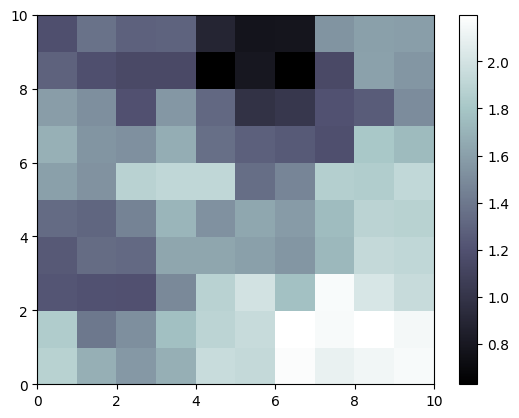

In [4]:
# =============================================================================
# 3. Data visualization
# =============================================================================
from pylab import bone, pcolor, colorbar
bone() # # Initialize the display window
pcolor(distance_matrix) # To display the som. The .T to put the transposed matrix. What is displayed is the MID of the nodes
colorbar() # To have the color legend. We will see that the MIDs go from 0 to 1, because they are scaled

max_value = np.amax(distance_matrix)
min_value = np.amin(distance_matrix)

list_mid = list(np.reshape(distance_matrix, (grid_size[0]*grid_size[1],)))
list_mid.sort()
list_mid = [j for j in list_mid if j > 1.48]
list_idx = [np.where(distance_matrix==j) for j in list_mid]
list_idx = [[idx_max[0][0], idx_max[1][0]] for idx_max in list_idx]

mappings = som.map_vects(X)